# Supervised Learning: Explaining Titanic Hypothesis with Decision Trees
___

_The problem we would like to solve is to determine if a Titanic's passenger would have survived, given her age, passenger class, and sex. We will work with the Titanic dataset that can be downloaded from http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic.txt._

Start by importing numpy, scikit-learn, and pyplot, the Python libraries we will be using in this chapter. Show the versions we will be using (in case you have problems running the notebooks).

In [1]:
import IPython
import sklearn as sk
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pydot
import pyparsing

print 'IPython version:', IPython.__version__
print 'numpy version:', np.__version__
print 'scikit-learn version:', sk.__version__
print 'matplotlib version:', matplotlib.__version__
print 'pydot version:', pydot.__version__
print 'pyparsing version:', pyparsing.__version__

IPython version: 4.0.1
numpy version: 1.10.1
scikit-learn version: 0.17
matplotlib version: 1.5.0
pydot version: 1.0.2
pyparsing version: 1.5.7


_Please note the pyparsing version. pydot has problems with pyparsing >= 2.0, you should have pyparsing 1.5.x. See the problem and a workaround at: http://stackoverflow.com/questions/15951748/pydot-and-graphviz-error-couldnt-import-dot-parser-loading-of-dot-files-will/21462609#21462609_

### Preprocessing

As usual, we should first load the dataset. The list of attributes it includes is: Ordinal, Class, Survived (0=no, 1=yes), Name, Age, Port of Embarkation, Home/Destination, Room, Ticket, Boat, and Sex. We will start by loading the dataset into a numpy array.. We assume it is located in the data/titanic.csv file

In [2]:
import csv
with open('data/titanic.csv', 'rb') as csvfile:
    titanic_reader = csv.reader(csvfile, delimiter=',', quotechar='"')
    
    # Header contains feature names
    row = titanic_reader.next()
    feature_names = np.array(row)
    
    # Load dataset, and target classes
    titanic_X, titanic_y = [], []
    for row in titanic_reader:  
        titanic_X.append(row)
        titanic_y.append(row[2]) # The target value is "survived"
    
    titanic_X = np.array(titanic_X)
    titanic_y = np.array(titanic_y)


Let's inspect how data looks. 

In [3]:
print feature_names, titanic_X[0], titanic_y[0]


['row.names' 'pclass' 'survived' 'name' 'age' 'embarked' 'home.dest' 'room'
 'ticket' 'boat' 'sex'] ['1' '1st' '1' 'Allen, Miss Elisabeth Walton' '29.0000' 'Southampton'
 'St Louis, MO' 'B-5' '24160 L221' '2' 'female'] 1


We will keep only class (1st,2nd,3rd), age (float), and sex (masc, fem) for our study. 

In [4]:
# we keep the class, the age and the sex
titanic_X = titanic_X[:, [1, 4, 10]]
feature_names = feature_names[[1, 4, 10]]
print feature_names
print titanic_X[12], titanic_y[12]


['pclass' 'age' 'sex']
['1st' 'NA' 'female'] 1


We have some problems with missing values ('NA') for the 'age' feature. To avoid this, we will use the mean value whenever we do not have data available.

In [5]:
ages = titanic_X[:, 1]
mean_age = np.mean(titanic_X[ages != 'NA', 1].astype(np.float))
titanic_X[titanic_X[:, 1] == 'NA', 1] = mean_age
print feature_names
print titanic_X[12], titanic_y[12]


['pclass' 'age' 'sex']
['1st' '31.1941810427' 'female'] 1


Now, class and sex are categorical classes, but most scikit-learn classifiers (in particular the Decision Trees we plan to use), expect real-valued attributes. We can easily convert sex  to a binary value (0=female,1=male). We will use the LabelEncoder class from scikit-learn:

In [6]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
label_encoder = enc.fit(titanic_X[:, 2])
print "Categorical classes:", label_encoder.classes_
integer_classes = label_encoder.transform(label_encoder.classes_)
print "Integer classes:", integer_classes
t = label_encoder.transform(titanic_X[:, 2])
titanic_X[:, 2] = t
print 'Feature names:',feature_names
print 'Features for instance number 12:',titanic_X[12], titanic_y[12]

Categorical classes: ['female' 'male']
Integer classes: [0 1]
Feature names: ['pclass' 'age' 'sex']
Features for instance number 12: ['1st' '31.1941810427' '0'] 1


Now, we have to convert the class. Since we have three different classes, we cannot convert to binary values (and using 0/1/2 values would imply an order, something we do not want). We use OneHotEncoder to get three different attributes:

In [7]:
from sklearn.preprocessing import OneHotEncoder

enc = LabelEncoder()
label_encoder = enc.fit(titanic_X[:, 0])
print "Categorical classes:", label_encoder.classes_
integer_classes = label_encoder.transform(label_encoder.classes_).reshape(3, 1)
print "Integer classes:", integer_classes
enc = OneHotEncoder()
one_hot_encoder = enc.fit(integer_classes)
# First, convert clases to 0-(N-1) integers using label_encoder
num_of_rows = titanic_X.shape[0]
t = label_encoder.transform(titanic_X[:, 0]).reshape(num_of_rows, 1)
# Second, create a sparse matrix with three columns, each one indicating if the instance belongs to the class
new_features = one_hot_encoder.transform(t)
# Add the new features to titanix_X
titanic_X = np.concatenate([titanic_X, new_features.toarray()], axis = 1)
#Eliminate converted columns
titanic_X = np.delete(titanic_X, [0], 1)
# Update feature names
feature_names = ['age', 'sex', 'first_class', 'second_class', 'third_class']
# Convert to numerical values
titanic_X = titanic_X.astype(float)
titanic_y = titanic_y.astype(float)


Categorical classes: ['1st' '2nd' '3rd']
Integer classes: [[0]
 [1]
 [2]]


In [8]:
print 'New feature names:',feature_names
print 'Values:',titanic_X[0]

New feature names: ['age', 'sex', 'first_class', 'second_class', 'third_class']
Values: [ 29.   0.   1.   0.   0.]


Split, as usual, training and testing sets

In [9]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(titanic_X, titanic_y, test_size=0.25, random_state=33)


### Decision Trees

Now, we can create a new DecisionTreeClassifier and use the fit method of the classifier to do the learning job.

In [10]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3,min_samples_leaf=5)
clf = clf.fit(X_train,y_train)

The decision tree we have built represents a series of decisions based on the training data. To classify an instance, we should answer the question at each node. For example, at our root node, the question is: Is sex<=0.5? (are we talking about a woman?). If the answer is yes, you go to the left child node in the tree; otherwise you go to the right child node. You keep answering questions (was she in the third class?, was she in the first class?, and was she below 13 years old?), until you reach a leaf. When you are there, the prediction corresponds to the target class that has most instances (that is if the answers are given to the previous questions). In our case, if she was a woman from second class, the answer would be 1 (that is she survived), and so on. Let's drawit, using pyplot:

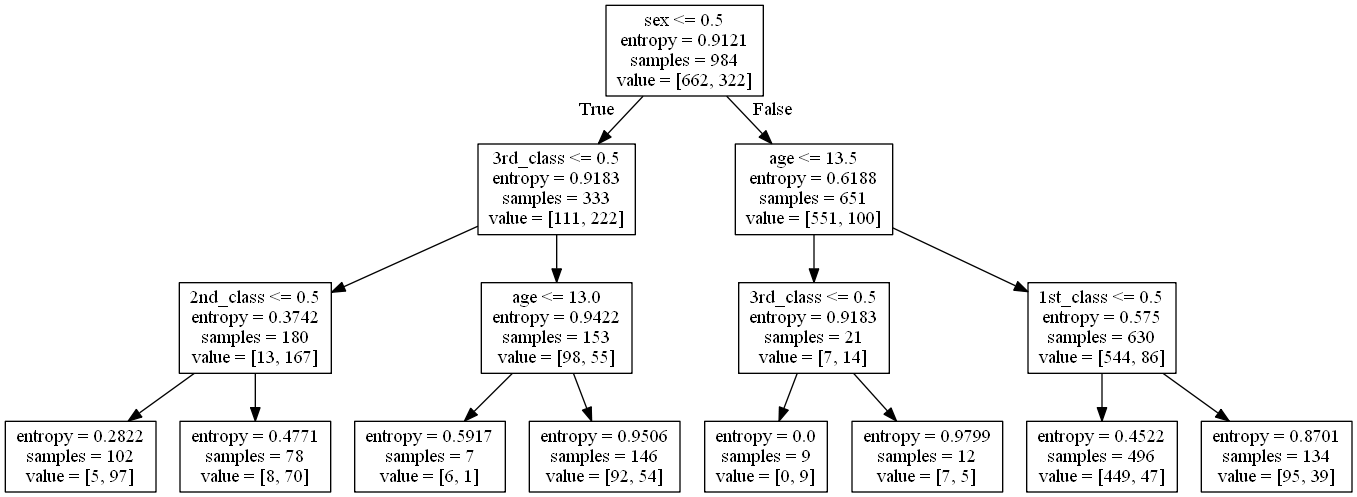

In [12]:
import StringIO
dot_data = StringIO.StringIO() 
tree.export_graphviz(clf, out_file=dot_data, feature_names=['age','sex','1st_class','2nd_class','3rd_class']) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
graph.write_png('titanic.png') 
from IPython.core.display import Image 
Image(filename='titanic.png')

Let's measure Accuracy, precision, recall, f1 in the training set

In [13]:
from sklearn import metrics
def measure_performance(X,y,clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True):
    y_pred=clf.predict(X)   
    if show_accuracy:
        print "Accuracy:{0:.3f}".format(metrics.accuracy_score(y,y_pred)),"\n"

    if show_classification_report:
        print "Classification report"
        print metrics.classification_report(y,y_pred),"\n"
        
    if show_confusion_matrix:
        print "Confusion matrix"
        print metrics.confusion_matrix(y,y_pred),"\n"
        
measure_performance(X_train,y_train,clf, show_classification_report=False, show_confusion_matrix=False)

Accuracy:0.838 



For this example, we will use an extreme case of cross- validation, named leave-one-out cross-validation. For each instance in the training sample, we train on the rest of the sample, and evaluate the model built on the only instance left out. After performing as many classifications as training instances, we calculate the accuracy simply as the proportion of times our method correctly predicted the class of the left-out instance, and found it is a little lower (as we expected) than the resubstitution accuracy on the training set.

In [14]:
from sklearn.cross_validation import cross_val_score, LeaveOneOut
from scipy.stats import sem

def loo_cv(X_train,y_train,clf):
    # Perform Leave-One-Out cross validation
    # We are preforming 1313 classifications!
    loo = LeaveOneOut(X_train[:].shape[0])
    scores=np.zeros(X_train[:].shape[0])
    for train_index,test_index in loo:
        X_train_cv, X_test_cv= X_train[train_index], X_train[test_index]
        y_train_cv, y_test_cv= y_train[train_index], y_train[test_index]
        clf = clf.fit(X_train_cv,y_train_cv)
        y_pred=clf.predict(X_test_cv)
        scores[test_index]=metrics.accuracy_score(y_test_cv.astype(int), y_pred.astype(int))
    print ("Mean score: {0:.3f} (+/-{1:.3f})").format(np.mean(scores), sem(scores))



In [15]:
loo_cv(X_train, y_train,clf)


Mean score: 0.837 (+/-0.012)


### Random Forests

A common criticism to decision trees is that once the training set is divided after answering a question, it is not possible to reconsider this decision. For example, if we divide men and women, every subsequent question would be only about men or women, and the method could not consider another type of question (say, age less than a year, irrespective of the gender). Random Forests try to introduce some level of randomization in each step, proposing alternative trees and combining them to get the final prediction. These types of algorithms that consider several classifiers answering the same question are called ensemble methods. 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10,random_state=33)
clf = clf.fit(X_train,y_train)
loo_cv(X_train,y_train,clf)

To evaluate performance on future data, evaluate on the training set and test on the evaluation set

In [17]:
clf_dt=tree.DecisionTreeClassifier(criterion='entropy', max_depth=3,min_samples_leaf=5)
clf_dt.fit(X_train,y_train)
measure_performance(X_test,y_test,clf_dt)



Accuracy:0.793 

Classification report
             precision    recall  f1-score   support

        0.0       0.77      0.96      0.85       202
        1.0       0.88      0.54      0.67       127

avg / total       0.81      0.79      0.78       329


Confusion matrix
[[193   9]
 [ 59  68]] 



___